## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from category_encoders import CountEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,  roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os
import joblib

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

random_state = 4012

In [10]:
import tensorflow as tf
import keras
from keras import backend as K
from keras import models
from keras import utils
from keras.layers import Input,Dense,LSTM,Dropout
from keras.models import Model,Sequential
from keras.optimizers import SGD,Adam,RMSprop

In [12]:
from scikeras.wrappers import KerasClassifier

## 2. Load Data

In [15]:
X_train = pd.read_csv("../Processed Data Files/X_train.csv")
y_train = pd.read_csv("../Processed Data Files/y_train.csv")

## 3. Model

In [16]:
# Combine them

scaler = StandardScaler()

onehot = OneHotEncoder(
    categories = [
            ['full time', 'contract', 'part time','flexi','other','unspecified'], # employment_type
            ['entry level', 'middle level', 'senior level', 'unspecified'], # required_experience
            ['high school or vocational degree', 'undergraduate', 'graduate', 'unspecified'], # required_education
    ],
    handle_unknown = 'ignore',  # <- Ignore unknown values (i.e. don't create a column for them)
)

freq_encoder = CountEncoder()

binary_columns = ['telecommuting', 'has_company_logo','has_questions', 'have_company_profile', 'have_requirements', 'have_benefits', 'have_category', 'high_salary']
numerical_columns = ['flesch_score_bin_ft','fk_grade_level_bin_ft', 'text_len']
onehot_columns = ['employment_type', 'required_experience','required_education']
freq_columns = ['location_country']

preprocessor = ColumnTransformer([
    # (nickname, transformer to apply, columns to apply to)
    ('binary', 'passthrough', binary_columns),  # <- 'passthrough' says to keep them but don't apply anything
    ('numerical', scaler, numerical_columns),   
    ('onehot', onehot, onehot_columns),
    ('frequency',freq_encoder, freq_columns),
],  remainder='passthrough')


In [17]:
X_train_processed = preprocessor.fit_transform(X_train)

In [18]:
# define metrics
def recall_m(y_true,y_pred):
  true_positives = K.sum(K.round(K.clip(y_true*y_pred,0,1)))
  possible_positives = K.sum(K.round(K.clip(y_true,0,1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true,y_pred):
  true_positives = K.sum(K.round(K.clip(y_true*y_pred,0,1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred,0,1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true,y_pred):
  precision = precision_m(y_true,y_pred)
  recall = recall_m(y_true,y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [35]:
# Function to create model, required for KerasClassifier
def create_model(init_mode='uniform',dropoutrates=0.2):
    # define model
    
    input_dim = X_train_processed.shape[1]
    nn_model = Sequential()
    nn_model.add(Dense(1024, activation=tf.nn.relu, kernel_initializer=init_mode,
                input_dim = input_dim))
    nn_model.add(Dropout(dropoutrates))
    nn_model.add(Dense(256, kernel_initializer=init_mode, activation=tf.nn.relu))
    nn_model.add(Dropout(dropoutrates))
    nn_model.add(Dense(32, kernel_initializer=init_mode, activation=tf.nn.relu))
    nn_model.add(Dropout(dropoutrates))
    nn_model.add(Dense(1, kernel_initializer=init_mode, activation=tf.nn.sigmoid))

    # compile the model
    nn_model.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=[f1_m])
    return nn_model
    

In [36]:
#### params
init_mode = ['uniform','glorot_uniform']
batch_size = [64, 128, 512]
dropoutrates = [0.2, 0.3, 0.5]
epochs = [10, 20, 30]
model_CV = KerasClassifier(build_fn=create_model,verbose=0,epochs=10, batch_size=128, dropoutrates=0.2,init_mode='uniform',optimizer=Adam())
# define the grid search parameters
param_grid = dict(init_mode=init_mode,batch_size=batch_size,dropoutrates=dropoutrates,epochs=epochs)
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, cv=3)

#RETURN the grid_result
grid_result = grid.fit(X_train_processed, y_train)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph

In [37]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.969488 using {'batch_size': 64, 'dropoutrates': 0.2, 'epochs': 30, 'init_mode': 'uniform'}
0.942268 (0.000411) with: {'batch_size': 64, 'dropoutrates': 0.2, 'epochs': 10, 'init_mode': 'uniform'}
0.941641 (0.000074) with: {'batch_size': 64, 'dropoutrates': 0.2, 'epochs': 10, 'init_mode': 'glorot_uniform'}
0.949948 (0.012992) with: {'batch_size': 64, 'dropoutrates': 0.2, 'epochs': 20, 'init_mode': 'uniform'}
0.941641 (0.000074) with: {'batch_size': 64, 'dropoutrates': 0.2, 'epochs': 20, 'init_mode': 'glorot_uniform'}
0.969488 (0.000195) with: {'batch_size': 64, 'dropoutrates': 0.2, 'epochs': 30, 'init_mode': 'uniform'}
0.941902 (0.000266) with: {'batch_size': 64, 'dropoutrates': 0.2, 'epochs': 30, 'init_mode': 'glorot_uniform'}
0.941641 (0.000074) with: {'batch_size': 64, 'dropoutrates': 0.3, 'epochs': 10, 'init_mode': 'uniform'}
0.941641 (0.000074) with: {'batch_size': 64, 'dropoutrates': 0.3, 'epochs': 10, 'init_mode': 'glorot_uniform'}
0.942842 (0.000369) with: {'batch_size': 

In [107]:
best_params = grid_result.best_params_
best_model = grid_result.best_estimator_

In [108]:
best_params

{'batch_size': 64, 'dropoutrates': 0.2, 'epochs': 30, 'init_mode': 'uniform'}

In [109]:
base_path = "../Models/" # path where the file is going to be saved in 

model_name = 'neural_network'

model_path = os.path.join(base_path, f'{model_name}.joblib')
f1_path = os.path.join(base_path, 'f1_m.joblib')

joblib.dump(best_model, model_path)
joblib.dump(f1_m, f1_path)

INFO:tensorflow:Assets written to: C:\Users\ly0322\AppData\Local\Temp\tmp3_lsepeo\assets


INFO:tensorflow:Assets written to: C:\Users\ly0322\AppData\Local\Temp\tmp3_lsepeo\assets


['../Models/f1_m.joblib']

## 4. Evaluation

In [70]:
X_test = pd.read_csv('../Processed Data Files/X_test.csv')
y_test = pd.read_csv('../Processed Data Files/y_test.csv')

def evaluate(x_test,y_test,name,model,preprocessor):

    print(model,"\n")
    
    y_pred = model.predict(preprocessor.transform(x_test))

    scores = {}
    scores["Accuracy"]  = accuracy_score(y_test,y_pred).round(3)
    scores["Precision"] = precision_score(y_test,y_pred,average="weighted").round(3)
    scores["Recall"]    = recall_score(y_test,y_pred,average="weighted").round(3)
    scores["F1"]        = f1_score(y_test,y_pred,average="weighted").round(3)
    scores["ROC AUC"]   = roc_auc_score(y_test,y_pred,average="weighted").round(3)
    scores = {name:scores}
    print(pd.DataFrame(scores))

    cm = confusion_matrix(y_test,y_pred)
    cm_plot = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues_r')
    cm_plot.set_xlabel('Predicted Values')
    cm_plot.set_ylabel('Actual Values')

KerasClassifier(
	model=None
	build_fn=<function create_model at 0x000001D176373160>
	warm_start=False
	random_state=None
	optimizer=<keras.src.optimizers.adam.Adam object at 0x000001D1B8A7C9A0>
	loss=None
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=30
	dropoutrates=0.2
	init_mode=uniform
	class_weight=None
) 

           neural_network
Accuracy            0.965
F1                  0.958
Precision           0.965
ROC AUC             0.704
Recall              0.965


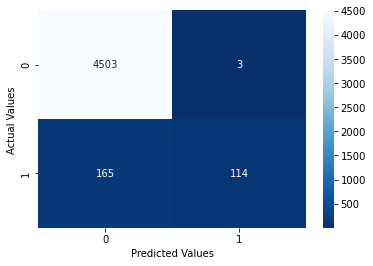

In [119]:
evaluate(X_test,y_test,'neural_network',best_model,preprocessor)